# Generative Adversarial Network (GAN) - Lab
#### Author: Kamil Barszczak

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import glob
import cv2
import os

from tensorflow.keras import layers, models, utils, regularizers, optimizers, losses
from tensorflow import keras, data
from tqdm import tqdm

#### Notebook parameters

In [2]:
dataset_path = 'E:/Data/CUB_200_2011'
train_test_split = 0.9
width, height = 64, 64
latent_dim = 64
batch = 64

#### Load and process data

In [3]:
bboxes = pd.read_csv(os.path.join(dataset_path, 'bounding_boxes.txt'), sep = " ", names=["id", "x", "y", "width", "height"]).astype(int)
annotations = pd.read_csv(os.path.join(dataset_path, 'images.txt'), sep = " ", names=["id", "path"])

processed = []
for index, row in tqdm(annotations.iterrows()):
    image_id = row.id
    image_path = row.path
    bbox  = bboxes[bboxes.id == image_id].iloc[0]
    
    img = cv2.imread(os.path.join(dataset_path, "images", image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img[bbox.y:bbox.y + bbox.height, bbox.x:bbox.x + bbox.width, :]
    img = cv2.resize(img, (width, height))
    img = tf.cast(img, 'float32') / 127.5 - 1
    processed.append(img)

11788it [02:02, 96.60it/s] 


In [4]:
processed = np.array(processed)
np.random.shuffle(processed)
split = int(len(processed) * train_test_split)

train_dataset = data.Dataset.from_tensor_slices(processed[:split]) \
                .shuffle(1024, reshuffle_each_iteration=True) \
                .batch(batch)

test_dataset = data.Dataset.from_tensor_slices(processed[split:]) \
                .batch(batch)

print("Train dataset:", train_dataset)
print("Test dataset:", test_dataset)

Train dataset: <BatchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>
Test dataset: <BatchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>


#### Create custom layers and model

In [5]:
class ImageProgress(keras.callbacks.Callback):
    def __init__(self, latent_dim, images=6, every_epoch=10):
        self.random_vectors = tf.random.normal((images, latent_dim))
        self.every_epoch = every_epoch

    def on_epoch_end(self, epoch, logs=None):
        if (epoch) % self.every_epoch == 0:
            generated_images = self.model.generator(self.random_vectors, training=False)
        
            fig = plt.figure(figsize=(12, 8))
            for i, image in enumerate(generated_images):
                fig.add_subplot(1, len(self.random_vectors), i + 1)
                plt.imshow((image.numpy() + 1) * 0.5)
                
            plt.show()

In [6]:
class DownsampleBlock(layers.Layer):
    def __init__(self, filters, size, strides=2, activation=layers.LeakyReLU(0.2), use_normalization=True, dropout=0.0, **kwargs):
        super(DownsampleBlock, self).__init__(**kwargs)
        
        self.filters = filters
        self.size = size
        self.strides = strides
        self.activation = activation
        self.use_normalization = use_normalization
        self.dropout = dropout
        
        self.stack = keras.Sequential()
        self.stack.add(layers.Conv2D(filters, size, strides, 'same'))
        
        if use_normalization:
            self.stack.add(layers.BatchNormalization(momentum=0.5))
            
        self.stack.add(activation)
        
        if dropout > 0:
            self.stack.add(layers.Dropout(dropout))
            
    def get_config(self):
        config = super().get_config()
        config.update({
            "filters": self.filters,
            "size": self.size,
            "strides": self.strides,
            "activation": self.activation,
            "use_normalization": self.use_normalization,
            "dropout": self.dropout,
        })
        return config

    def call(self, inputs):
        return self.stack(inputs)

In [7]:
class UpsampleBlock(layers.Layer):
    def __init__(self, filters, size, strides=2, activation=layers.ReLU(), use_normalization=True, dropout=0.0, **kwargs):
        super(UpsampleBlock, self).__init__(**kwargs)
        
        self.filters = filters
        self.size = size
        self.strides = strides
        self.activation = activation
        self.use_normalization = use_normalization
        self.dropout = dropout
        
        self.stack = keras.Sequential()
        self.stack.add(layers.Conv2DTranspose(filters, size, strides, 'same'))
        
        if use_normalization:
            self.stack.add(layers.BatchNormalization(momentum=0.5))
            
        self.stack.add(activation)
        
        if dropout > 0:
            self.stack.add(layers.Dropout(dropout))
            
    def get_config(self):
        config = super().get_config()
        config.update({
            "filters": self.filters,
            "size": self.size,
            "strides": self.strides,
            "activation": self.activation,
            "use_normalization": use_self.normalization,
            "dropout": self.dropout
        })
        return config
    
    def call(self, inputs):
        return self.stack(inputs)

In [8]:
class Generator(layers.Layer):
    def __init__(self, output_activation='tanh', output_strides=1, output_kernel_size=3,
                 dense_layers_info=[
                     ((4, 4, 256), True, layers.ReLU(), 0)
                 ],  # shape, normalization, activation, dropout,
                 upsample_layers_info=[
                     (256, 3, 2, True, layers.LeakyReLU(0.2), 0.0),
                     (128, 3, 2, True, layers.LeakyReLU(0.2), 0.0),
                     (64, 3, 2, True, layers.LeakyReLU(0.2), 0.0),
                     (32, 3, 2, True, layers.LeakyReLU(0.2), 0.0)
                 ]  # filters, size, strides, normalization, activation, dropout
                 , **kwargs):
        super(Generator, self).__init__(**kwargs)
        
        self.output_activation = output_activation
        self.output_strides = output_strides
        self.output_kernel_size = output_kernel_size
        self.dense_layers_info = dense_layers_info
        self.upsample_layers_info = upsample_layers_info
            
        self.stack = keras.Sequential()
        
        for index, dl in enumerate(dense_layers_info):
            self.stack.add(layers.Dense(dl[0][0]*dl[0][1]*dl[0][2], name=f"gen_dense_{index}"))
            if dl[1]:
                self.stack.add(layers.BatchNormalization(momentum=0.5))
            if dl[2] is not None:
                self.stack.add(dl[2])
            if dl[3] > 0:
                self.stack.add(layers.Dropout(dl[3]))
            
        self.stack.add(layers.Reshape(dense_layers_info[-1][0], name="gen_reshape"))
        
        for index, ul in enumerate(upsample_layers_info):
            self.stack.add(UpsampleBlock(
                filters=ul[0],
                size=ul[1],
                strides=ul[2],
                use_normalization=ul[3], 
                activation=ul[4], 
                dropout=ul[5], 
                name=f"gen_up_{index}"
            ))
        
        self.stack.add(layers.Conv2D(3, kernel_size=output_kernel_size, strides=output_strides, activation=output_activation, padding="same", name="gen_conv_outputs"))
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "output_activation": self.output_activation,
            "output_strides": self.output_strides,
            "output_kernel_size": self.output_kernel_size,
            "dense_layers_info": self.dense_layers_info,
            "upsample_layers_info": self.upsample_layers_info,
        })
        return config
        
    def call(self, inputs):
        return self.stack(inputs)

In [9]:
class Discriminator(layers.Layer):
    def __init__(self, 
                 output_activation='sigmoid',
                 dense_layers_info=[
                     (128, True, layers.ReLU(), 0.0)
                 ],  # shape, normalization, activation, dropout
                 downsample_layers_info=[
                     (64, 3, 2, True, layers.LeakyReLU(0.2), 0.0),
                     (128, 3, 2, True, layers.LeakyReLU(0.2), 0.0),
                     (256, 3, 2, True, layers.LeakyReLU(0.2), 0.0),
                 ]  # filters, size, strides, normalization, activation, dropout
                 , **kwargs):
        super(Discriminator, self).__init__(**kwargs)
            
        self.output_activation = output_activation
        self.dense_layers_info = dense_layers_info
        self.downsample_layers_info = downsample_layers_info
        
        self.stack = keras.Sequential()
        
        for index, ul in enumerate(downsample_layers_info):
            self.stack.add(DownsampleBlock(
                filters=ul[0],
                size=ul[1],
                strides=ul[2],
                use_normalization=ul[3], 
                activation=ul[4], 
                dropout=ul[5], 
                name=f"dis_down_{index}"
            ))
            
        self.stack.add(layers.Flatten(name="dis_flatten"))
            
        for index, dl in enumerate(dense_layers_info):
            self.stack.add(layers.Dense(dl[0], name=f"dis_dense_{index}"))
            if dl[1]:
                self.stack.add(layers.BatchNormalization(momentum=0.5))
            if dl[2] is not None:
                self.stack.add(dl[2])
            if dl[3] > 0:
                self.stack.add(layers.Dropout(dl[3]))
        
        self.stack.add(layers.Dense(1, activation=output_activation, name="gen_conv_outputs"))

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_activation": self.output_activation,
            "dense_layers_info": self.dense_layers_info,
            "downsample_layers_info": self.downsample_layers_info,
        })
        return config
    
    def call(self, inputs):
        return self.stack(inputs)

In [31]:
class GAN(keras.Model):
    def __init__(self, generator, discriminator):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        
    def compile(self, g_optimizer, d_optimizer, g_loss_fn, d_loss_fn, latent_dim, **kwargs):
        super().compile(**kwargs)
        
        self.g_loss_mean = keras.metrics.Mean(name="g_loss")
        self.d_loss_mean = keras.metrics.Mean(name="d_loss")
        
        self.real_acc = keras.metrics.BinaryAccuracy(name="real_acc")
        self.generated_acc = keras.metrics.BinaryAccuracy(name="gen_acc")
        
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        
        self.g_loss_fn = g_loss_fn
        self.d_loss_fn = d_loss_fn
        self.latent_dim = latent_dim
        
    @property
    def metrics(self):
        return [
            self.g_loss_mean,
            self.d_loss_mean,
            self.real_acc,
            self.generated_acc,
        ]
    
    
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        
        # 1. Train the discriminator
        
        # Generate some images
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim)) # Get noise for generator input
        generated_images = self.generator(random_noise) # Generate images for discriminator training step
        
        # Create labels for the discriminator
        # We assume 1 - real image, 0 - fake image + noise (important trick!)
        real_labels = tf.ones((batch_size, 1)) -  tf.random.uniform((batch_size,1)) * 0.15
        generated_labels = tf.random.uniform((batch_size,1)) * 0.15
        
        # Train the network, update weights manually
        # GradientTape is used to record all calculations inside the network and calculate gradient during backprop
        with tf.GradientTape() as tape:            
            # Divide into two steps because of BatchNormalization
            real_preds = self.discriminator(real_images)            # Predict classes for real images
            generated_preds = self.discriminator(generated_images)  # Predict classes for generated images

            # Labels and predictions of [real,fake] are merged for a discriminator loss function
            d_loss = self.d_loss_fn(
                tf.concat([real_labels, generated_labels], axis=0), # true labels
                tf.concat([real_preds, generated_preds], axis=0)  # predicted labels
            )     
          
        # Calculate discriminator gradients
        d_grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        # Apply weight changes
        self.d_optimizer.apply_gradients(zip(d_grads,self.discriminator.trainable_weights))

        #2. Train the generator
        #[2*] Because discriminator is trained on 2*batch_size number of samples (fake and real)
        random_noise = tf.random.normal(shape=(2*batch_size, self.latent_dim)) #get noise for generator input
        
        # During training, the generator tries to deceive the discriminator that it can generate realistic images
        # Therefore, we use "real (1)" labels for the generator
        misleading_labesl = tf.ones((2*batch_size, 1))
        
        with tf.GradientTape() as tape:
            generated_images = self.generator(random_noise) # Generate images
            fake_preds = self.discriminator(generated_images,training=False)
            g_loss = self.g_loss_fn(misleading_labesl, fake_preds)  

        # Calculate generator gradients
        g_grads = tape.gradient(g_loss, self.generator.trainable_weights)

        # Apply weight changes
        self.g_optimizer.apply_gradients(zip(g_grads,self.generator.trainable_weights))
        
        # Uupdate metrics
        self.g_loss_mean.update_state(g_loss)
        self.d_loss_mean.update_state(d_loss)
        self.real_acc.update_state(1.0, real_preds)
        self.generated_acc.update_state(0.0, generated_preds)
            
        return {'g_loss': g_loss, 'd_loss': d_loss, 
               'real_acc': self.real_acc.result(), 'gen_acc': self.generated_acc.result()}

#### Build and train the model

In [38]:
gen = Generator(
    dense_layers_info=[
        ((4, 4, 128), False, layers.ReLU(), 0.1)
    ],
    upsample_layers_info=[
        (64, 3, 2, True, layers.LeakyReLU(0.2), 0.0),
        (48, 3, 2, True, layers.LeakyReLU(0.2), 0.0),
        (32, 3, 2, True, layers.LeakyReLU(0.2), 0.0),
        (16, 3, 2, True, layers.LeakyReLU(0.2), 0.0)
    ],
    name="generator"
)

gen_inputs = layers.Input(shape=(latent_dim, ))
gen_outputs = gen(gen_inputs)
generator = keras.Model(inputs=gen_inputs, outputs=gen_outputs)
generator.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 64)]              0         
                                                                 
 generator (Generator)       (None, 64, 64, 3)         254163    
                                                                 
Total params: 254,163
Trainable params: 253,843
Non-trainable params: 320
_________________________________________________________________


In [39]:
dis = Discriminator(
    output_activation='sigmoid',
    dense_layers_info=[
#         (16, False, layers.ReLU(), 0.1)
    ],
    downsample_layers_info=[
        (16, 5, 2, True, layers.LeakyReLU(0.2), 0.0),
        (32, 5, 2, True, layers.LeakyReLU(0.2), 0.0),
        (64, 5, 2, True, layers.LeakyReLU(0.2), 0.0),
        (128, 5, 2, True, layers.LeakyReLU(0.2), 0.0)
    ],
    name="discriminator"
)
dis_inputs = layers.Input(shape=(width, height, 3))
dis_outputs = dis(dis_inputs)
discriminator = keras.Model(inputs=dis_inputs, outputs=dis_outputs)
discriminator.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 discriminator (Discriminato  (None, 1)                273249    
 r)                                                              
                                                                 
Total params: 273,249
Trainable params: 272,769
Non-trainable params: 480
_________________________________________________________________


In [40]:
gan = GAN(
    generator,
    discriminator
)

gan.compile(
    optimizers.Adam(0.00015, beta_1=0.5, beta_2=0.9),  # generator
    optimizers.Adam(0.0002, beta_1=0.5, beta_2=0.9),  # discriminator
    losses.BinaryCrossentropy(),
    losses.BinaryCrossentropy(),
    latent_dim
)

Epoch 1/250
166/166 [==============================] - ETA: 0s - g_loss: 3.1010 - d_loss: 0.2703 - real_acc: 0.9961 - gen_acc: 0.9188

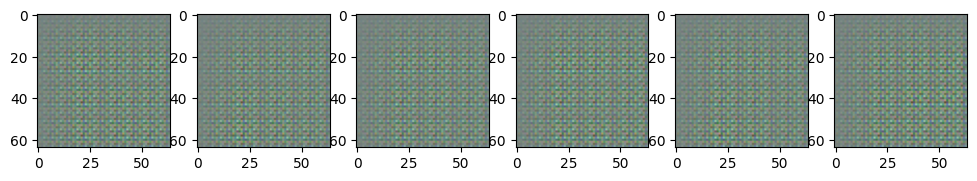

166/166 [==============================] - 14s 71ms/step - g_loss: 3.1010 - d_loss: 0.2703 - real_acc: 0.9961 - gen_acc: 0.9188
Epoch 2/250
166/166 [==============================] - 11s 68ms/step - g_loss: 3.1130 - d_loss: 0.3811 - real_acc: 0.9864 - gen_acc: 0.9930
Epoch 3/250
166/166 [==============================] - 11s 68ms/step - g_loss: 2.8650 - d_loss: 0.2714 - real_acc: 0.9743 - gen_acc: 0.9884
Epoch 4/250
166/166 [==============================] - 11s 68ms/step - g_loss: 3.0980 - d_loss: 0.4975 - real_acc: 0.9731 - gen_acc: 0.9953
Epoch 5/250
166/166 [==============================] - 11s 68ms/step - g_loss: 2.9981 - d_loss: 0.4158 - real_acc: 0.9399 - gen_acc: 0.9842
Epoch 6/250
166/166 [==============================] - 11s 68ms/step - g_loss: 2.1356 - d_loss: 0.3298 - real_acc: 0.9617 - gen_acc: 0.9963
Epoch 7/250
166/166 [==============================] - 12s 70ms/step - g_loss: 1.4060 - d_loss: 0.3317 - real_acc: 0.9426 - gen_acc: 0.9809
Epoch 8/250
166/166 [===========

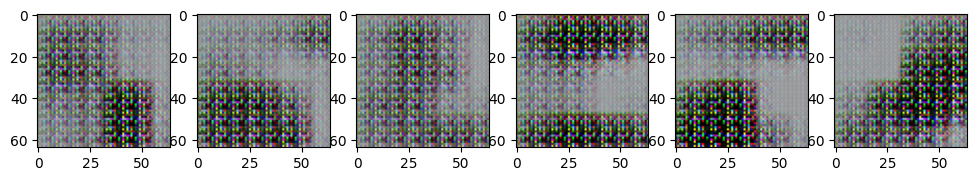

166/166 [==============================] - 12s 69ms/step - g_loss: 2.7957 - d_loss: 0.3181 - real_acc: 0.9184 - gen_acc: 0.9813
Epoch 12/250
166/166 [==============================] - 11s 68ms/step - g_loss: 1.6940 - d_loss: 0.3540 - real_acc: 0.9290 - gen_acc: 0.9890
Epoch 13/250
166/166 [==============================] - 12s 70ms/step - g_loss: 1.5879 - d_loss: 0.3351 - real_acc: 0.9263 - gen_acc: 0.9870
Epoch 14/250
166/166 [==============================] - 11s 69ms/step - g_loss: 2.3839 - d_loss: 0.3238 - real_acc: 0.9186 - gen_acc: 0.9830
Epoch 15/250
166/166 [==============================] - 11s 67ms/step - g_loss: 1.7571 - d_loss: 0.4079 - real_acc: 0.9209 - gen_acc: 0.9830
Epoch 16/250
166/166 [==============================] - 11s 68ms/step - g_loss: 2.5210 - d_loss: 0.3986 - real_acc: 0.9042 - gen_acc: 0.9677
Epoch 17/250
166/166 [==============================] - 11s 67ms/step - g_loss: 1.9924 - d_loss: 0.5803 - real_acc: 0.9109 - gen_acc: 0.9714
Epoch 18/250
166/166 [====

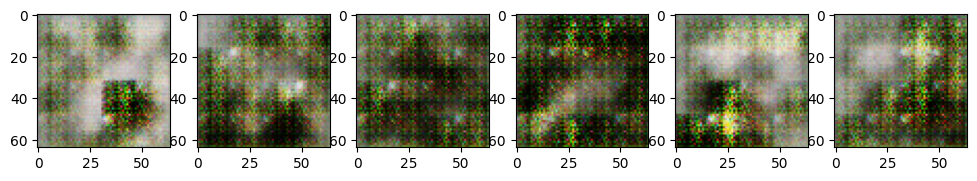

166/166 [==============================] - 12s 69ms/step - g_loss: 2.5457 - d_loss: 0.3860 - real_acc: 0.8814 - gen_acc: 0.9627
Epoch 22/250
166/166 [==============================] - 11s 67ms/step - g_loss: 1.1485 - d_loss: 0.4374 - real_acc: 0.8594 - gen_acc: 0.9412
Epoch 23/250
166/166 [==============================] - 11s 67ms/step - g_loss: 2.7767 - d_loss: 0.3610 - real_acc: 0.8599 - gen_acc: 0.9351
Epoch 24/250
166/166 [==============================] - 11s 67ms/step - g_loss: 2.2538 - d_loss: 0.3948 - real_acc: 0.8786 - gen_acc: 0.9568
Epoch 25/250
166/166 [==============================] - 11s 67ms/step - g_loss: 1.5212 - d_loss: 0.3982 - real_acc: 0.8864 - gen_acc: 0.9686
Epoch 26/250
166/166 [==============================] - 11s 68ms/step - g_loss: 2.1856 - d_loss: 0.3876 - real_acc: 0.8654 - gen_acc: 0.9514
Epoch 27/250
166/166 [==============================] - 11s 68ms/step - g_loss: 2.0357 - d_loss: 0.3852 - real_acc: 0.8847 - gen_acc: 0.9640
Epoch 28/250
166/166 [====

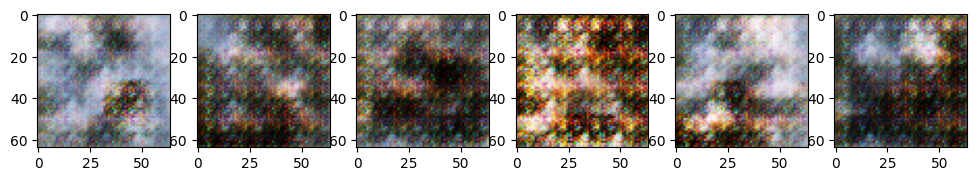

166/166 [==============================] - 12s 72ms/step - g_loss: 2.4887 - d_loss: 0.3117 - real_acc: 0.8875 - gen_acc: 0.9524
Epoch 32/250
166/166 [==============================] - 11s 68ms/step - g_loss: 1.7659 - d_loss: 0.3862 - real_acc: 0.8830 - gen_acc: 0.9587
Epoch 33/250
166/166 [==============================] - 11s 68ms/step - g_loss: 2.2848 - d_loss: 0.4519 - real_acc: 0.8820 - gen_acc: 0.9578
Epoch 34/250
166/166 [==============================] - 11s 67ms/step - g_loss: 2.1118 - d_loss: 0.4282 - real_acc: 0.8465 - gen_acc: 0.9259
Epoch 35/250
166/166 [==============================] - 11s 67ms/step - g_loss: 2.5236 - d_loss: 0.4199 - real_acc: 0.8232 - gen_acc: 0.9130
Epoch 36/250
166/166 [==============================] - 11s 68ms/step - g_loss: 1.9275 - d_loss: 0.3986 - real_acc: 0.8590 - gen_acc: 0.9376
Epoch 37/250
166/166 [==============================] - 11s 68ms/step - g_loss: 1.9847 - d_loss: 0.5322 - real_acc: 0.8515 - gen_acc: 0.9255
Epoch 38/250
166/166 [====

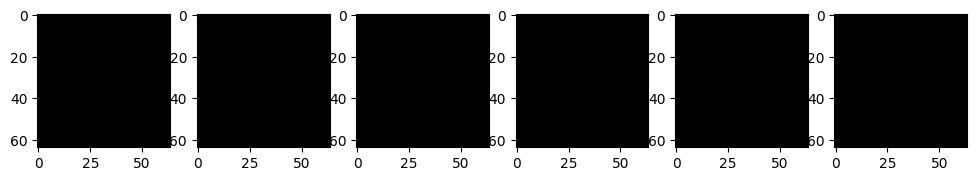

166/166 [==============================] - 12s 69ms/step - g_loss: nan - d_loss: nan - real_acc: 0.0000e+00 - gen_acc: 1.0000
Epoch 42/250
166/166 [==============================] - 11s 67ms/step - g_loss: nan - d_loss: nan - real_acc: 0.0000e+00 - gen_acc: 1.0000
Epoch 43/250
 76/166 [============>.................] - ETA: 6s - g_loss: nan - d_loss: nan - real_acc: 0.0000e+00 - gen_acc: 1.0000

KeyboardInterrupt: 

In [41]:
history = gan.fit(
    train_dataset,
    epochs=250,
    callbacks=[ImageProgress(latent_dim)]
) 

In [ ]:
generator.save_weights("generator.h5")
discriminator.save_weights("discriminator.h5")

# https://stackoverflow.com/questions/69498990/operatornotallowedingrapherror-using-a-tf-tensor-as-a-python-bool-is-not-al